# Calibrating a Network Using Mercury Intrusion Data

Mercury intrusion porosimetry (MIP) is a common technique in the study of porous media used to determine the pore size distribution of a porous material. There are two reasons why one would want to fit a PNM to MIP data.

The first reason is to more accurately obtain pore size distributions from MIP data.  MIP data is universally interpreted using a 'bundle of tubes' model, which neglects the shielding effect that occurs when large pore bodies are 'shielded' behind smaller ones.  A more nuanced interpretation of MIP data requires using a pore network model to fit the data, then obtaining the pore and throat size distribution of the model. This is not usually done because it is quite a bit more difficult, and the additional accuracy is not necessarily justified. 

The second reason is that often we wish to generate a cubic pore network that is representative of a specific material so that we can then perform additional simulations using the network.  This is called *network calibration*.  Calibration can also involve fitting of permeability and formation factor data as well, since successfully fitting more metrics means a better calibration. 

In this example, we will show how OpenPNM can be used to simulate mercury intrusion and estimate the pore size distribution of a network, and we'll compare this experimental values, and iterate until they match. 

## Import Packages

In [333]:
import numpy as np
import openpnm as op
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as spst

op.visualization.set_mpl_style()
np.random.seed(10)
ws = op.Workspace()
ws.settings["loglevel"] = 40
np.set_printoptions(precision=5)

## Import Data for a Sandstone

For this work we will use the porosimetry data from [Characterization of the pore structure of reservoir rocks with the aid
of serial sectioning analysis, mercury porosimetry and network simulation" by  Tsakiroglou and Payatakes in Advances in Water Resources 23 (2000) 773-789](http://doi.org/10.1016/S0309-1708(00)00002-6).  The data we extracted from Figure.8 in that paper using a graph digitizer:

Let's import the MIP data for this sample:

In [334]:
df = pd.read_csv('Sandstone.csv')
print(df)

       Pc [Pa]     S_Hg
0      12056.4  0.00122
1      15162.4  0.00368
2      17630.0  0.00741
3      23693.0  0.00860
4      30708.0  0.01607
5      36799.0  0.01979
6      44633.0  0.02351
7      49752.0  0.02599
8      52522.0  0.03474
9      55439.0  0.05476
10     55449.0  0.05473
11     57820.0  0.06977
12     59569.0  0.09980
13     62089.0  0.16613
14     63563.0  0.22244
15     65092.0  0.25123
16     66585.0  0.37262
17     68232.0  0.34759
18     69833.0  0.42518
19     71069.0  0.47100
20     71085.0  0.45271
21     76355.0  0.54039
22     76802.0  0.54156
23    101289.0  0.60534
24    117732.0  0.63785
25    135188.0  0.67913
26    160014.0  0.70663
27    203630.0  0.73037
28    222870.0  0.74787
29    267020.0  0.76787
30    348080.0  0.79660
31    437710.0  0.80783
32    696280.0  0.83528
33   1148210.0  0.87899
34   1860000.0  0.90268
35   2352900.0  0.92016
36   3975500.0  0.94885
37   5214900.0  0.95882
38   7353000.0  0.98253
39   9821400.0  0.99375
40  11698800.0  

We have 45 pressure points, and the mercury volume has already been normalized by the porosity, which was 18% in this case. 

Before we get into the network modeling, it is a good idea to convert the pressure data to pore size data using the bundle of tubes model to get a first approximation of the sizes to expect:

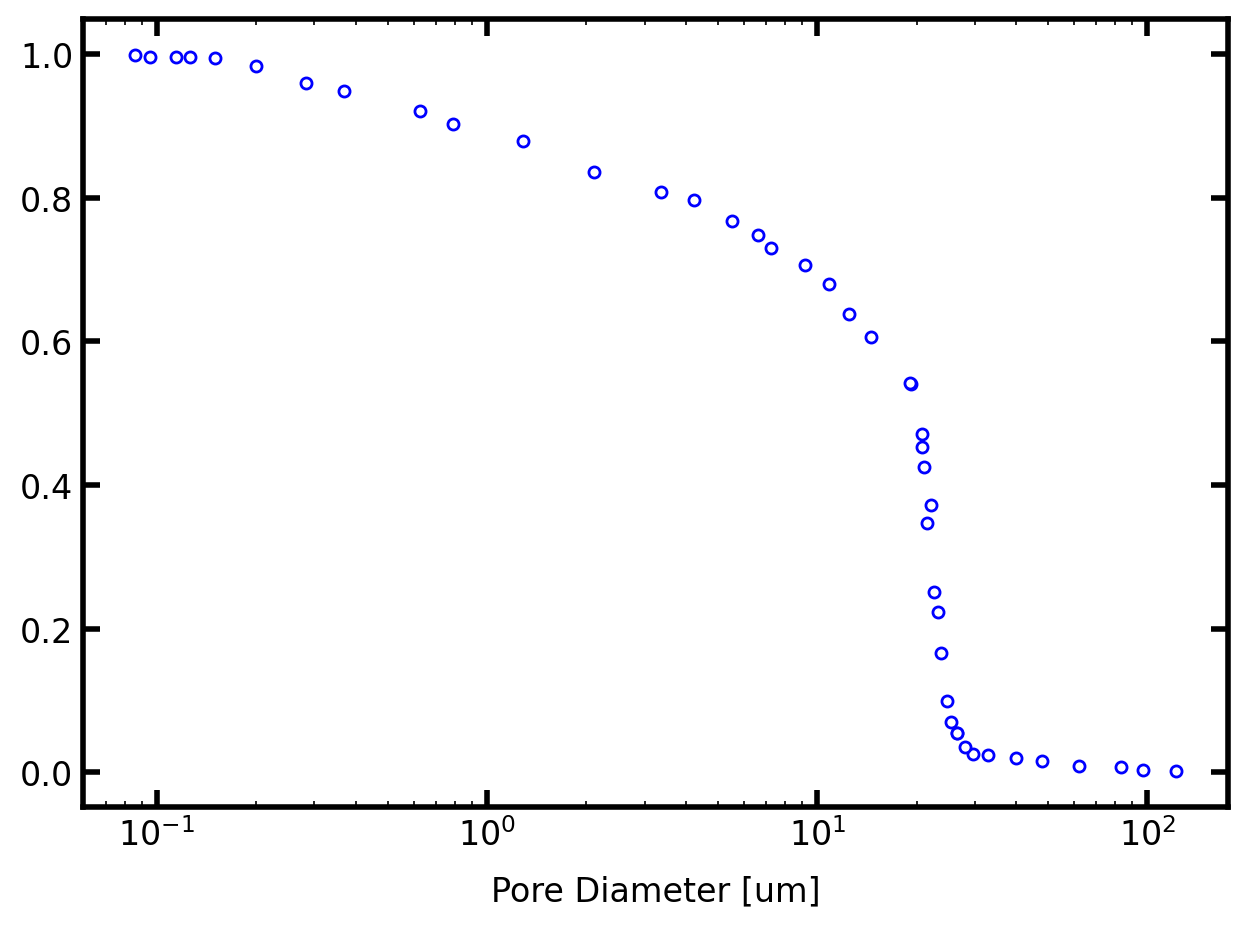

In [335]:
df['R'] = -2*0.480*np.cos(np.deg2rad(140))/df['Pc [Pa]']
fig, ax = plt.subplots()
ax.semilogx(2*df['R']*1e6, df['S_Hg'], 'b.')
ax.set_xlabel('Pore Diameter [um]');

We can see that we should aim to have pore diameters in the range of 20-30 um.  

## Network

We may want to use a large network for some future simulations, but for the sake of the fitting process we can use a relatively small network to get the parameters.  Here we will use use a simple cubic network with 15 pores per side and a spacing of 40 um.  Note that we *can adjust* this spacing if it let's us match the data more closely.

In [336]:
pn = op.network.Cubic(shape=[15, 15, 15], spacing=30e-6)
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x2315ad6f220>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.coords                                                   3375 / 3375
  3  throat.conns                                                  9450 / 9450
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.surface                                                         1178
  3  throat.surface                                                       2352
  4  pore.left                                                             225
  5 

## Add Geometrical Properties

The network object only contains topological and spatial information.  We need to assign some pore and throat sizes.  Since one of the objectives of this tutorial is to shine some light on the use of pore-scale models and how to customize them, we will *not* use the convenient pre-packages model collections, but instead add all the models we need by hand.  Let's start by assigning sizes to the pore bodies:

### Pore Sizes

It is possible to produce sizes directly from a statistical distribution, like ``scipy.stats.weibull_min.rvs(<args>)``, however, we are going to do it the "hard way" since this will help us later.  We'll start by assigning random seed values between 0 and 1 to the network:

In [337]:
np.random.seed(0)  # Set the state of the random number generator to "0"
pn['pore.seed'] = np.random.rand(pn.Np)

Now let's define a statistical distribution. The Weibull distribution is common since it has mostly small pore and a long tail of a few large pores, which is typical of many porous materials.

In [338]:
dst = spst.weibull_min(c=1.9, loc=1e-7, scale=20e-6)

The above line creates what is called a "frozen object", meaning that `dst` is now a `weibull_min` object with the parameters `c`, `loc`, and `scale` fixed at their given values. 

Let's quickly look at some values from this distribution to see if the parameters we chose are a decent starting point. The `rvs` method returns the requested number of randomly generated values from the frozen distribution.

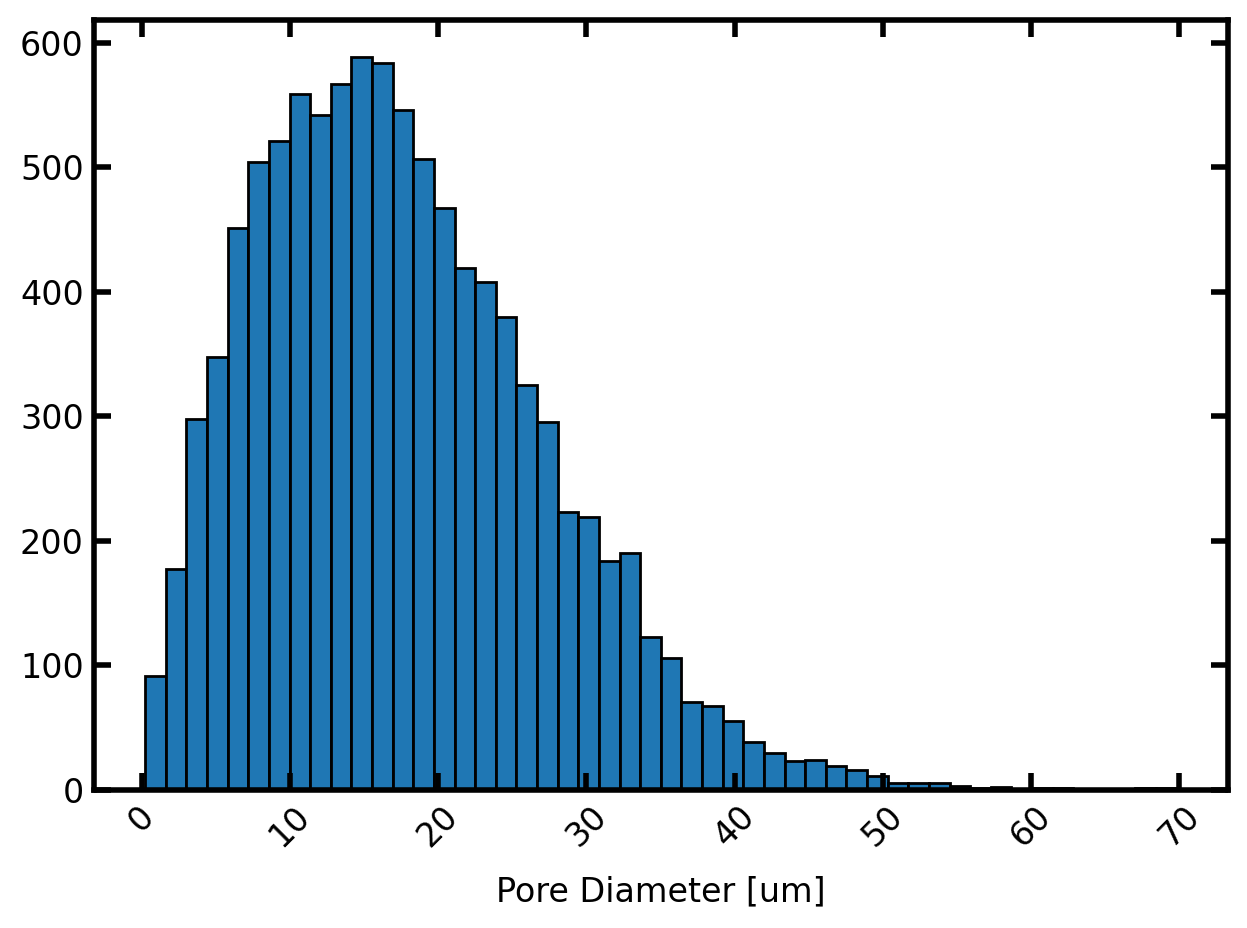

In [339]:
fig, ax = plt.subplots()
ax.hist(dst.rvs(10000)*1e6, bins=50, edgecolor='k')
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('Pore Diameter [um]');

This looks pretty good.  The minimum value (`loc`) was set to 100 nm, and the `scale` of 20 um positions the distribution well within our expected range.  Lastly, the `c` value controls the skew, which has created a slighly elongated tail, but nothing too  extreme.  Only a few values will be larger than the network spacing of 40 um, which we will revisit later.

### Finding Pore Sizes Given Random Seeds between 0 and 1
Before moving on, let's first examine how we can produce random values given seed values between 0 and 1.  Below is a plot of the cumulative probability distribution (`cdf`). The y-axis is the `pn['pore.seed']` values, and the x-axis is the pore size value.  The `'pore.seed'` values are chosen at random between 0 and 1, and the size values can be found by doing a reverse "look-up", shown by the red lines.

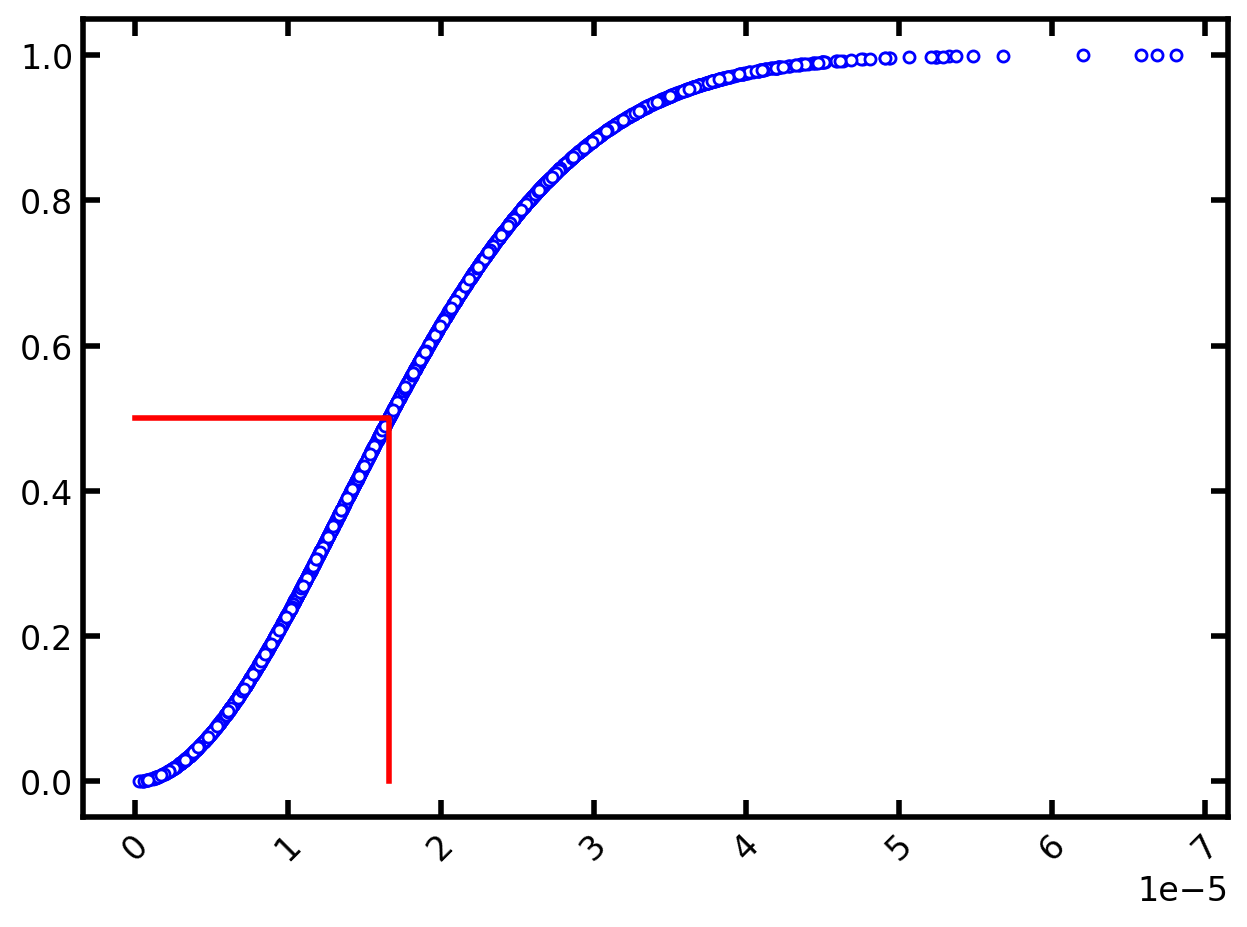

In [340]:
fig, ax = plt.subplots()
ax.plot(dst.ppf(pn['pore.seed']), pn['pore.seed'], 'b.')
ax.plot([0, dst.ppf(0.5), dst.ppf(0.5)], [0.5, 0.5, 0.0], 'r-')
ax.tick_params(axis='x', labelrotation=45);

There are two important advantages to this approach.

Firstly, we can limit the range of seed values, for instance from 0.1 to 0.9, which will prevent any abnormally large values that might occur if a point far out on the tail end of the distribution is choosen (like 0.9999).  

Seconly, this simplifies the process of creating spatially correlated pore sizes since there are many way to generate correlated random numbers bewteen 0 and 1 (i.e. `porespy.generators.fractal_noise`). We won't go into that here, but it was used to create anisotropic networks in [this work](https://doi.org/10.1016/j.jpowsour.2007.04.059).

## Apply Distribution to the Network

We can now use this model to generate our pore sizes for the network.  We can do this easy way or the right way.  

First the easy way: Let's just assign values from the frozen distribution to the network directly.

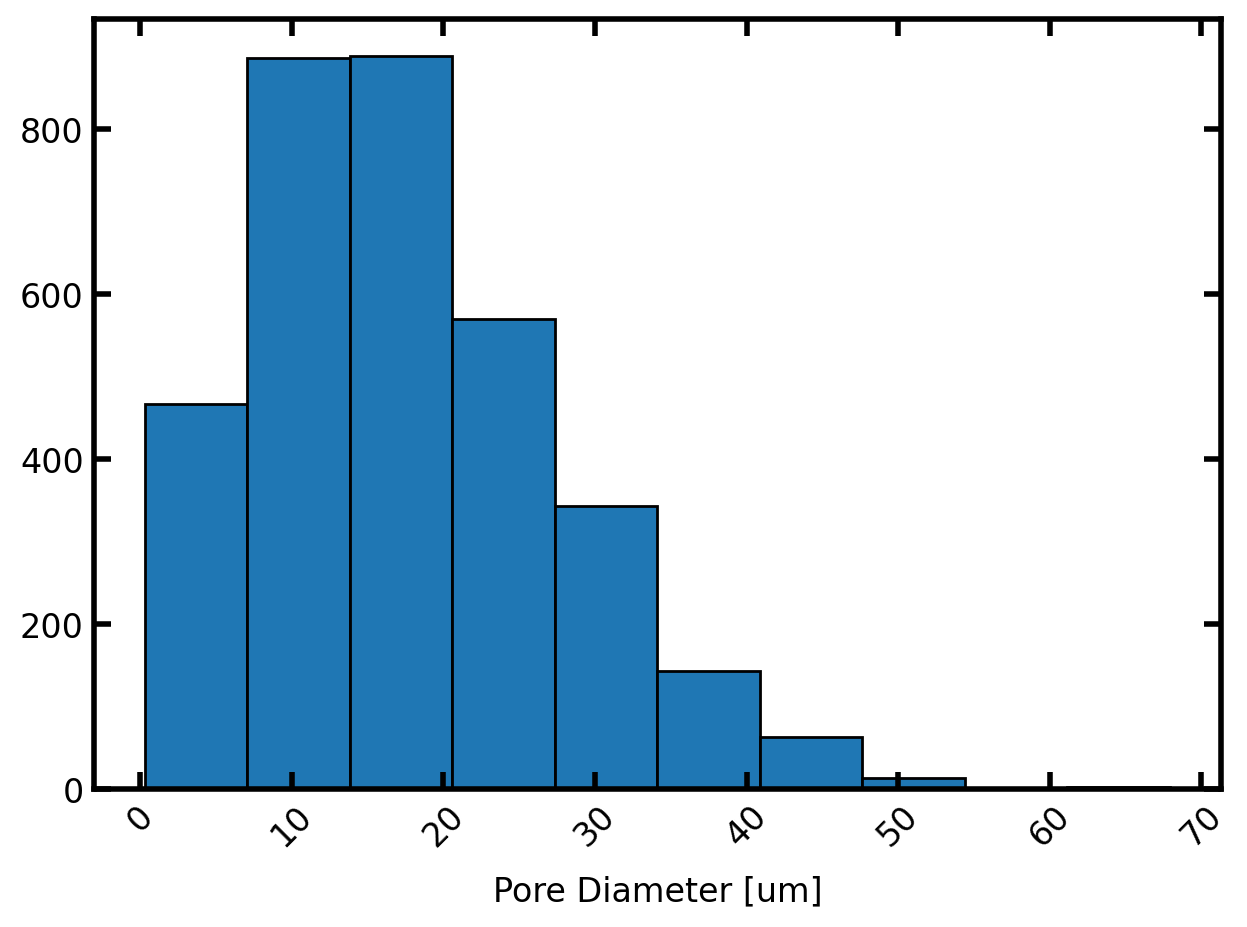

In [341]:
pn['pore.diameter'] = dst.rvs(pn.Np)
fig, ax = plt.subplots()
ax.hist(pn['pore.diameter']*1e6, edgecolor='k')
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('Pore Diameter [um]');

The problem with this approach is that if we were to change the values of 'pore.seed', it would have no effect on the pore sizes.  This is not really an issue in the current example since we haven't used a model for 'pore.seed' values. However, a common use case might be to re-run a simulation N times to ensure the results are repeatable. If a model for 'pore.seed' were used, then we could just do `pn.regenerate_models()`, and OpenPNM would generate a new set of 'pore.seed' values, then it would recompute all the values that depend on 'pore.seed', starting with 'pore.diameter', and then 'pore.volume', and so forth.

To properly leverage the OpenPNM models regeneration features, we need to assign the statistical model (ie. 'weibull_min') to the network as a pore-scale model. OpenPNM includes a `generic_distribution` function, which accepts a pre-initialized `scipy.stats` distribution, like the one we defined above.  Let's also add a model for 'pore.seed' values, and truncate the values in the range of [0.0 to 0.98].

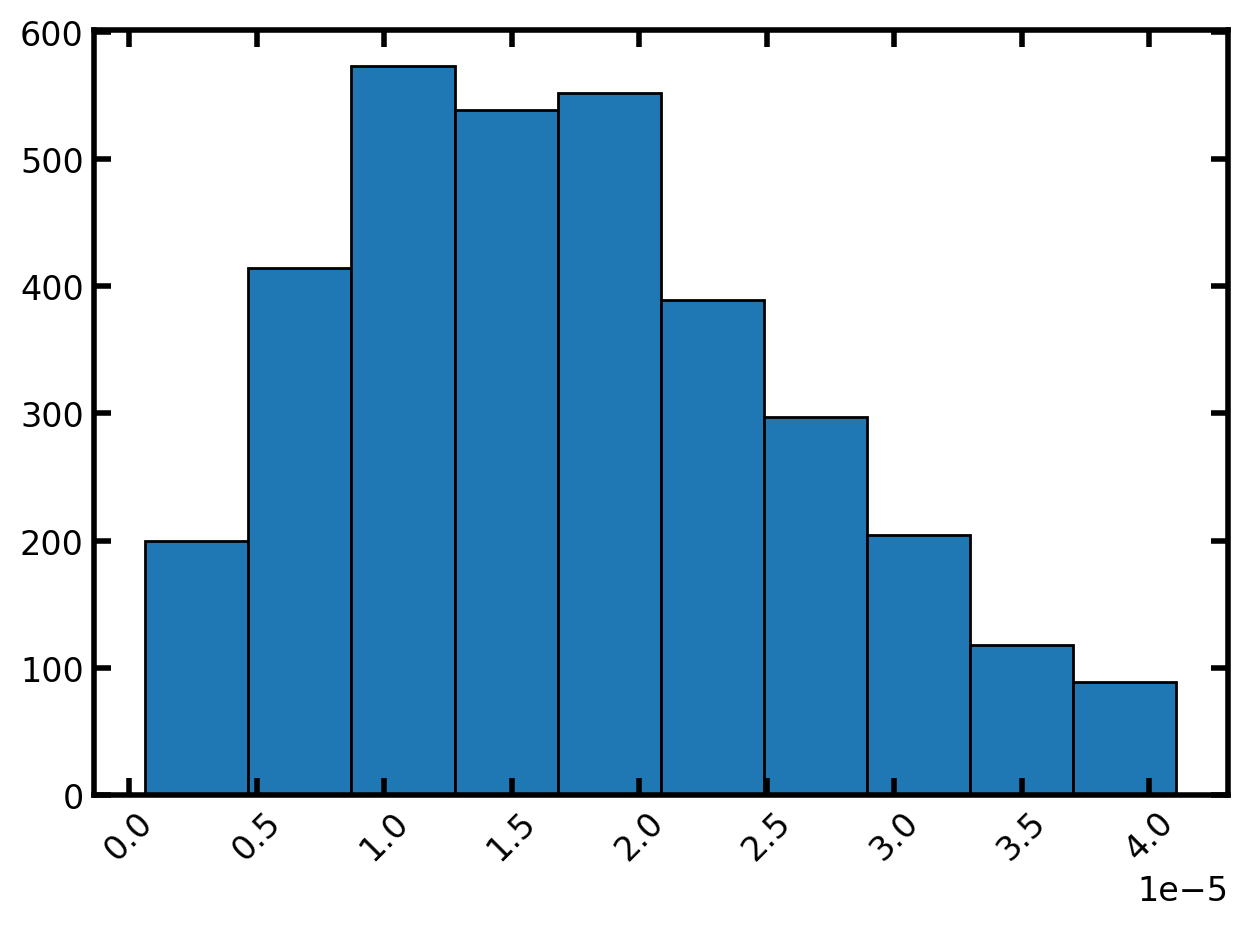

In [342]:
f = op.models.geometry.pore_seed.random
pn.add_model(propname='pore.seed',
             model=f,
             num_range=[0.0, 0.98])
pn.add_model(propname='pore.diameter',
             model=op.models.geometry.pore_size.generic_distribution,
             func=dst,
             seeds='pore.seed')
pn.regenerate_models()
fig, ax = plt.subplots()
ax.hist(pn['pore.diameter'], edgecolor='k')
ax.tick_params(axis='x', labelrotation=45);

### Throat Sizes

When assigning throat sizes it must be remembered that throat sizes should *usually* be smaller than the two pores which they connect.  This is not *strictly* necessary, but it is consistent with the general picture of a porous material, and it also make other calculations quite a bit simpler. 
|
There are two methods we can use to assign throat sizes. We can assume that each throat is smaller than the two pores it connects by some factor, i.e., `0.5 * min(d1, d2)`.  Alternatively, we can assign each throat a `seed` value, which is taken as the minimum of the seed value in the two pores it connects, then use those values in any desired size distribution (which should produce smaller values than the chosen pore size distribution given the same seed values).

Let's do both:

In [343]:
pn.add_model(propname='throat.diameter_1', 
             model=op.models.misc.from_neighbor_pores,
             prop='pore.diameter',
             mode='min')
pn.add_model(propname='throat.seed', 
             model=op.models.misc.from_neighbor_pores,
             prop='pore.seed',
             mode='min')
pn.add_model(propname='throat.diameter_2',
             model=op.models.geometry.throat_size.generic_distribution,
             func=dst)

And we can chose which of these becomes the "official" throat diameter, and apply some scaling to the values if needed using:

In [344]:
pn.add_model(propname='throat.diameter',
             model=op.models.misc.scaled,
             prop='throat.diameter_1',  # This could also be 'throat.diameter_2'
             factor=0.6,  # This could be 1.0 if no scaling is desired
)

Now let's plot the two distributions together:

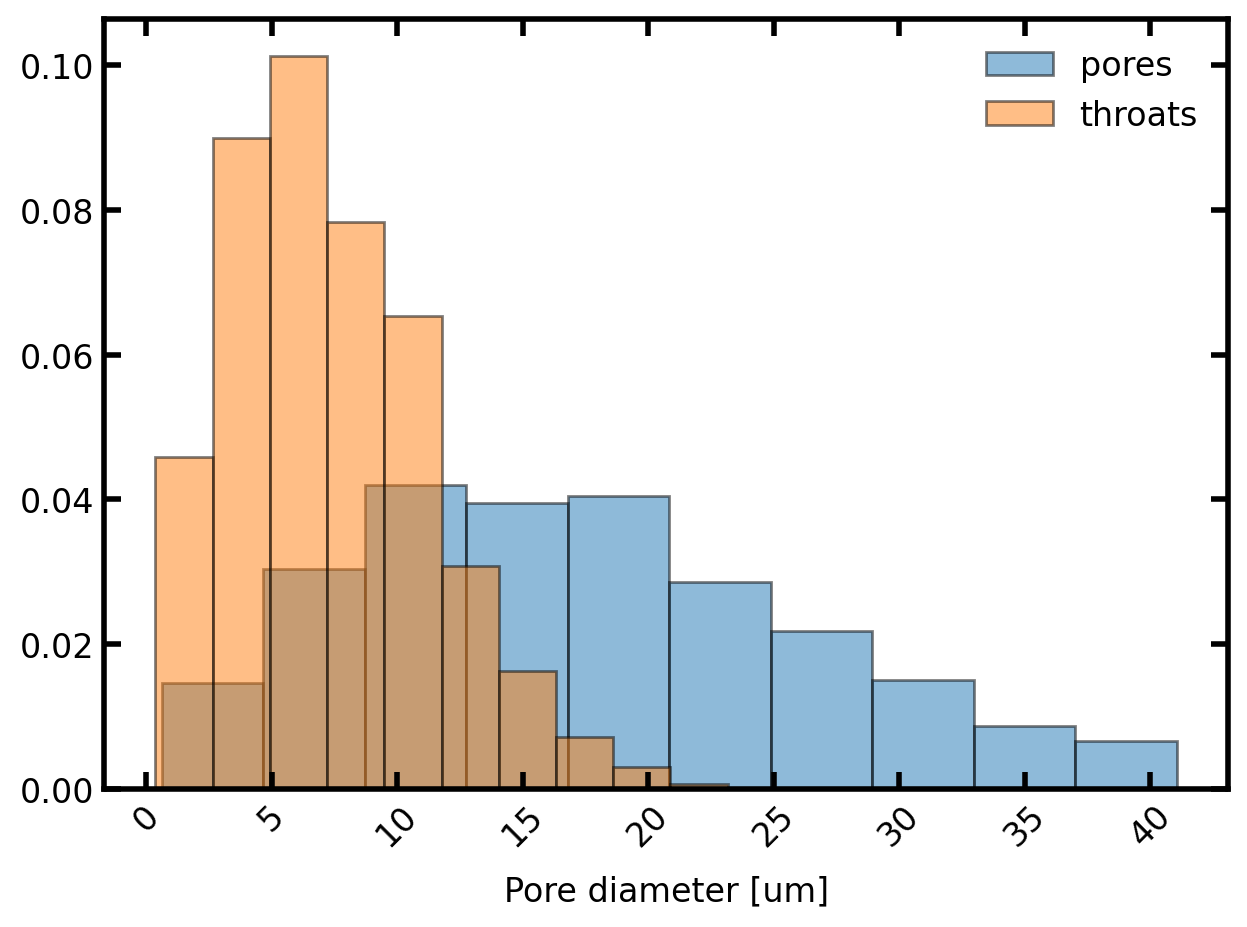

In [345]:
fig, ax = plt.subplots()
ax.hist(pn['pore.diameter']*1e6, edgecolor='k', density=True, alpha=0.5, label='pores')
ax.hist(pn['throat.diameter']*1e6, edgecolor='k', density=True, alpha=0.5, label='throats')
ax.tick_params(axis='x', labelrotation=45)
ax.legend()
ax.set_xlabel('Pore diameter [um]');

To fully define the geometry for this network we need to assign pore and throat volumes.  This requires making an assumption about their shapes, since spheres and cubes have different volumes. Let's assume spherical pores:

In [346]:
pn.add_model(propname='pore.volume',
             model=op.models.geometry.pore_volume.sphere)

To compute the throat volume we need to know not only the diameter but also the length.  Things get a bit nuanced here because of the way that spherical pore bodies and cylindrical throat overlap.  There is a 'lens' shaped region of overlap whose volume will be counted twice.  So the following set of models is necessary: 

In [347]:
pn.add_model(propname='throat.length',
             model=op.models.geometry.throat_length.spheres_and_cylinders)
pn.add_model(propname='throat.total_volume',
             model=op.models.geometry.throat_volume.cylinder)
pn.add_model(propname='throat.lens_volume', 
            model=op.models.geometry.throat_volume.lens)
pn.add_model(propname='throat.volume', 
             model=op.models.misc.difference,
             props=['throat.total_volume', 'throat.lens_volume'])

## Phase

Next we create a phase object which contains the thermophysical properties of the invading fluid, such as surface tension. In the case of mercury intrusion, the invading fluid is of course mercury!

In [348]:
hg = op.phase.Mercury(network=pn)

## Add Physics

To simulate mercury intrusion, we will need to calulate the capillary pressure of the throats in the network. The capillary pressure can be calculated using the Washburn equation as provided below.

$$ P_C = \frac{-2\sigma cos(\theta)}{R_T} $$


In [349]:
hg.add_model(propname='throat.entry_pressure',
             model=op.models.physics.capillary_pressure.washburn)
hg.regenerate_models()

The washburn model will fetch the surface tension and contact angle from the mercury phase object while the throat radius is fetched from the network object. 

## Perform Mercury Intrusion

Now that all the required objects and models are setup, we can perform the capillary pressure curve simulation.  The mercury intrusion experiment is a "drainage" since the wetting fluid (i.e. rarefied air) is being 'drained' while the non-wetting fluid is invading.  

When setting the boundary conditions for this simulation all the surface pores should be considered as inlets since the experiment starts with the sample fully surrounded by mercury.  The ``Cubic`` class has a `'pore.surface'` label which we can use:

In [350]:
mip = op.algorithms.Drainage(network=pn, phase=hg)
mip.set_inlet_BC(pores=pn.pores('surface'))
mip.run()

Performing drainage simulation:   0%|          | 0/25 [00:00<?, ?it/s]

Now let's compare the simulation to the experimental data:

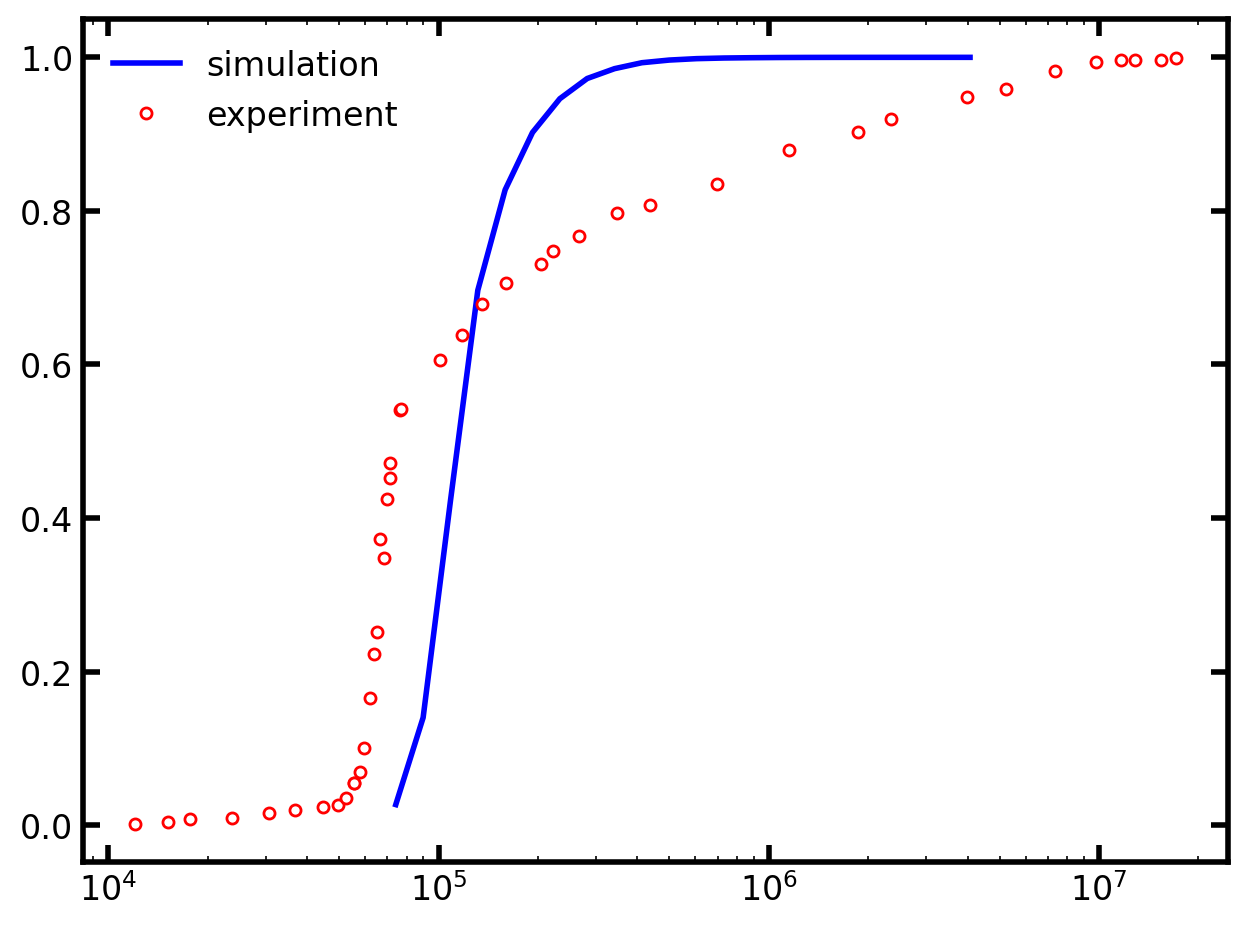

In [351]:
pc_sim = mip.pc_curve()
fig, ax = plt.subplots()
ax.semilogx(*pc_sim, 'b-', label='simulation')
ax.semilogx(df['Pc [Pa]'], df['S_Hg'], 'r.', label='experiment')
ax.legend();

The agreement is surprizingly good for a first guess.  We probably want to make the throat sizes in the network a little bit larger to shift the curve left.  Recall that to compute the throat sizes we took the minimum size of the two neighboring pores and scaled it by 0.5. Let's adjust this scale factor.  We could readd a new model over the old one, or just adjust the stored parameters of the current one:

Performing drainage simulation:   0%|          | 0/25 [00:00<?, ?it/s]

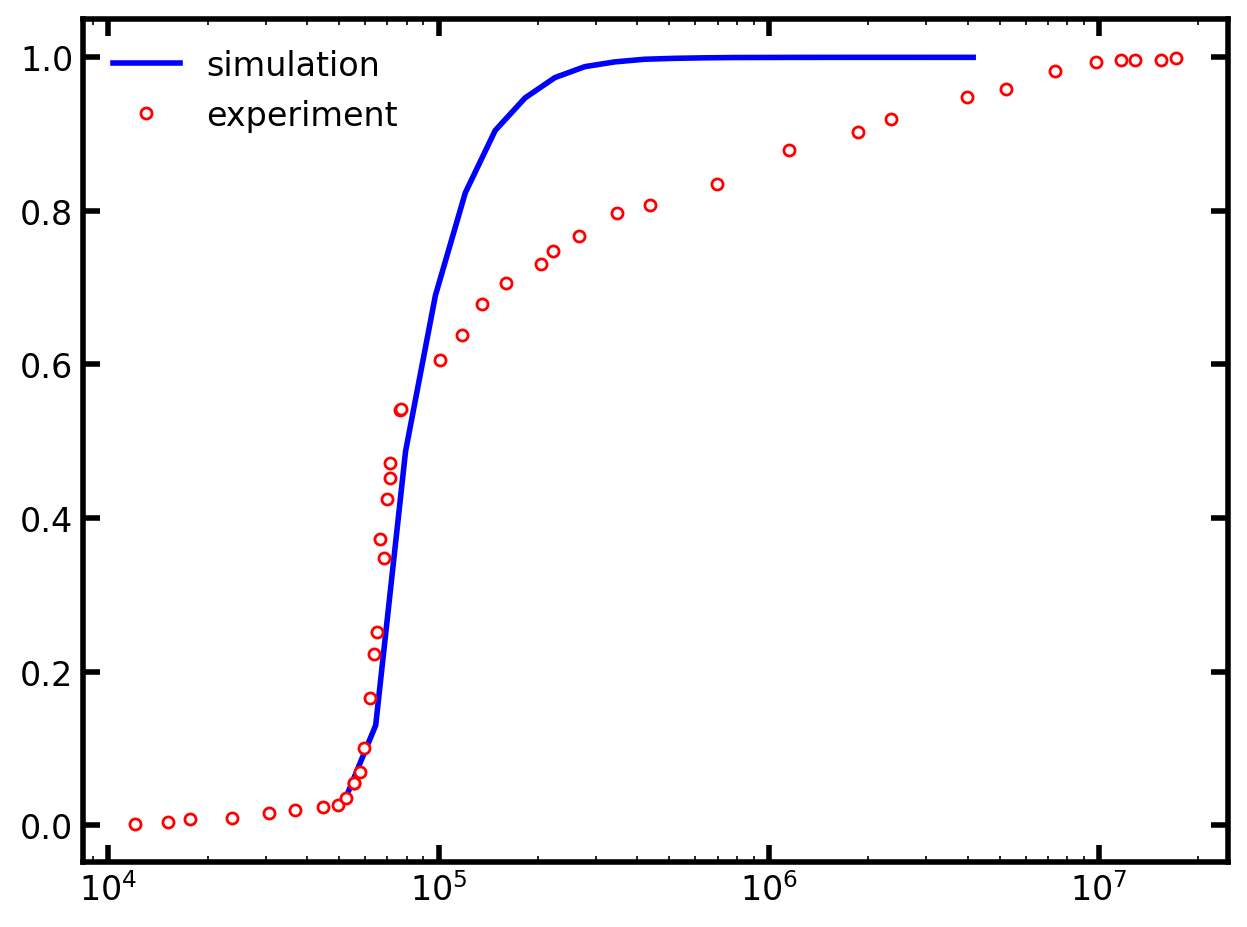

In [352]:
pn.models['throat.diameter@all']['factor'] = 0.9
pn.regenerate_models()
hg.regenerate_models()
mip = op.algorithms.Drainage(network=pn, phase=hg)
mip.set_inlet_BC(pores=pn.pores('surface'))
mip.run()
pc_sim = mip.pc_curve()
fig, ax = plt.subplots()
ax.semilogx(*pc_sim, 'b-', label='simulation')
ax.semilogx(df['Pc [Pa]'], df['S_Hg'], 'r.', label='experiment')
ax.legend();

This helped quite a bit, but is still not great.  

The process of adjusting the pore and throat size distributions to match MIP curves has been studied by many people over the years in attempts to automate it.  OpenPNM does not have any automated algorithms for this (at least not at the moment), so we must forge ahead by hand.  The next thing to try would be to shift the pore size distributions to slightly higher values. We can play with the `c` value which is the skewness of the curve, and we can adjust the `scale` which shifts it to higher sizes.

Let's plot a new distribution on top of the current values on the network to see how things will change:

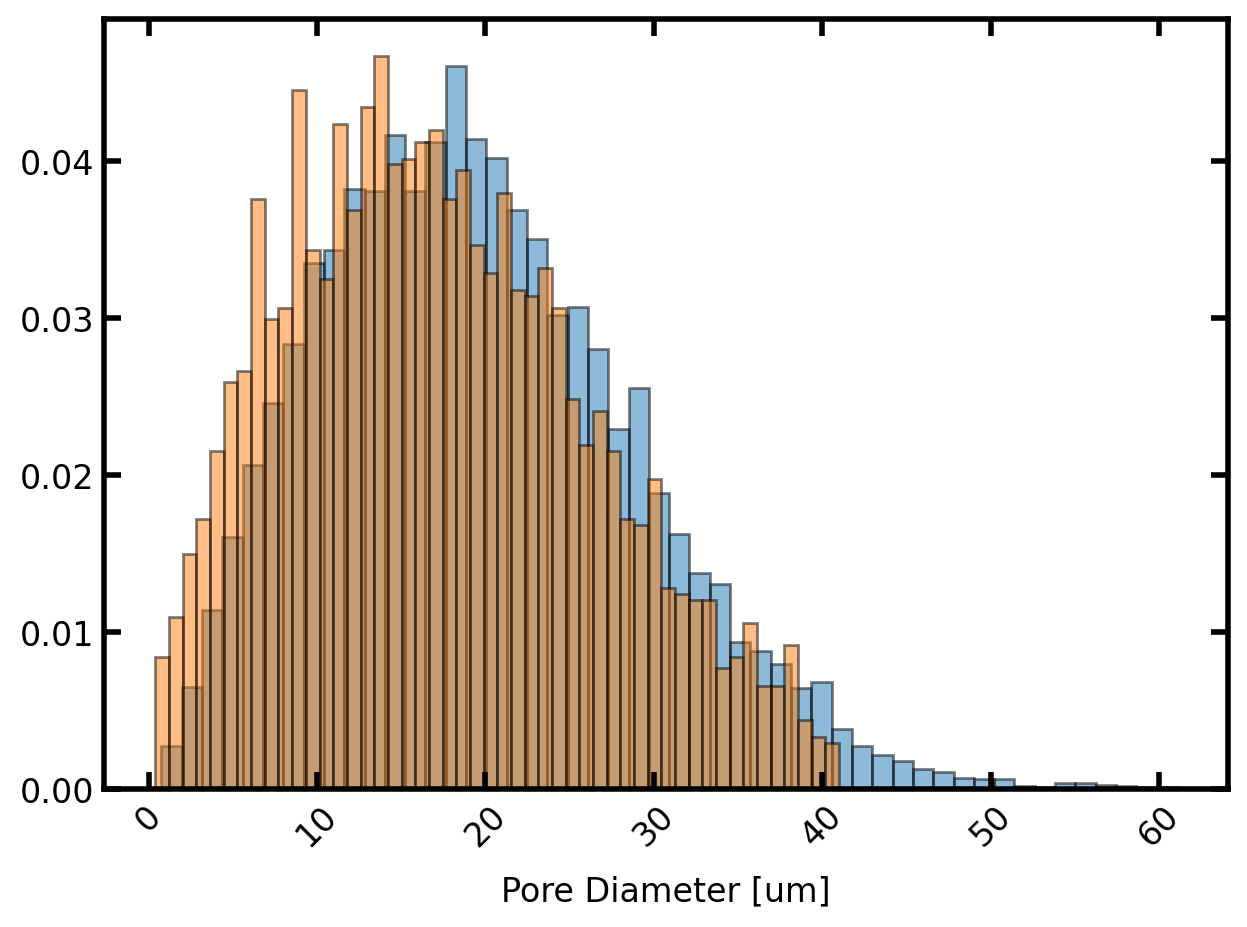

In [353]:
dst = spst.weibull_min(c=2.2, loc=1e-7, scale=22e-6)
fig, ax = plt.subplots()
ax.hist(dst.rvs(10000)*1e6, bins=50, edgecolor='k', density=True, alpha=0.5)
ax.hist(pn['pore.diameter']*1e6, bins=50, edgecolor='k', density=True, alpha=0.5)
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('Pore Diameter [um]');

Since the new distribution looks like an improvement, let's add it to the network and repeat:

Performing drainage simulation:   0%|          | 0/25 [00:00<?, ?it/s]

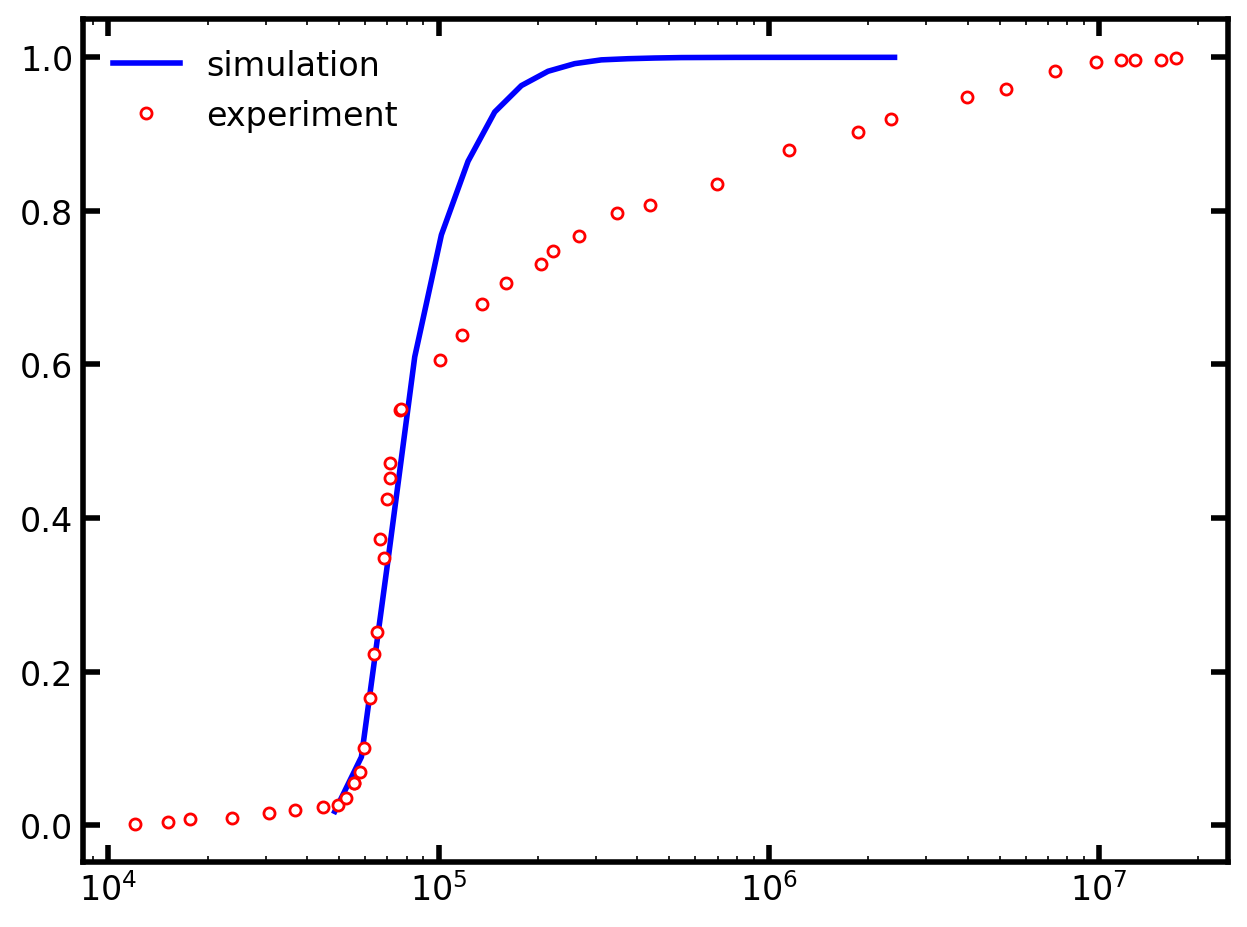

In [354]:
pn.models['pore.diameter@all']['func'] = dst
pn.regenerate_models()
hg.regenerate_models()
mip = op.algorithms.Drainage(network=pn, phase=hg)
mip.set_inlet_BC(pores=pn.pores('surface'))
mip.run()
pc_sim = mip.pc_curve()
fig, ax = plt.subplots()
ax.semilogx(*pc_sim, 'b-', label='simulation')
ax.semilogx(df['Pc [Pa]'], df['S_Hg'], 'r.', label='experiment')
ax.legend();

Now teh fit in the low pressure region is nearly perfect. Of course the high pressure region is not fitting at all, but as dicussed by Tsakiroglou and Payatakes in their paper, this sandstone has a dual porosity or microporosity, which is not resolved by the basic network used here.  

## Check Geometric Consistency

We used a spacing of 40 um when creating the network, but we have some pores which are greater than 30 um in diameter.  If two of these pores happen to be beside each other, then geometric 'inconsistencies' will arise.  For instance, the throat volume might have some negative values:

In [360]:
print(pn['pore.diameter'].max())
print(pn['throat.volume'].min())

4.098593686530963e-05
-1.174072534598329e-14


To remedy this we can increase the lattice spacing of the network. Instead of creating an entirely new network, this can be done simply by scaling the pore coordinates directly.  We will scale the spacing to 50 um instead of 30 um, by multiplying all the coordinates by 50/30:

Performing drainage simulation:   0%|          | 0/25 [00:00<?, ?it/s]

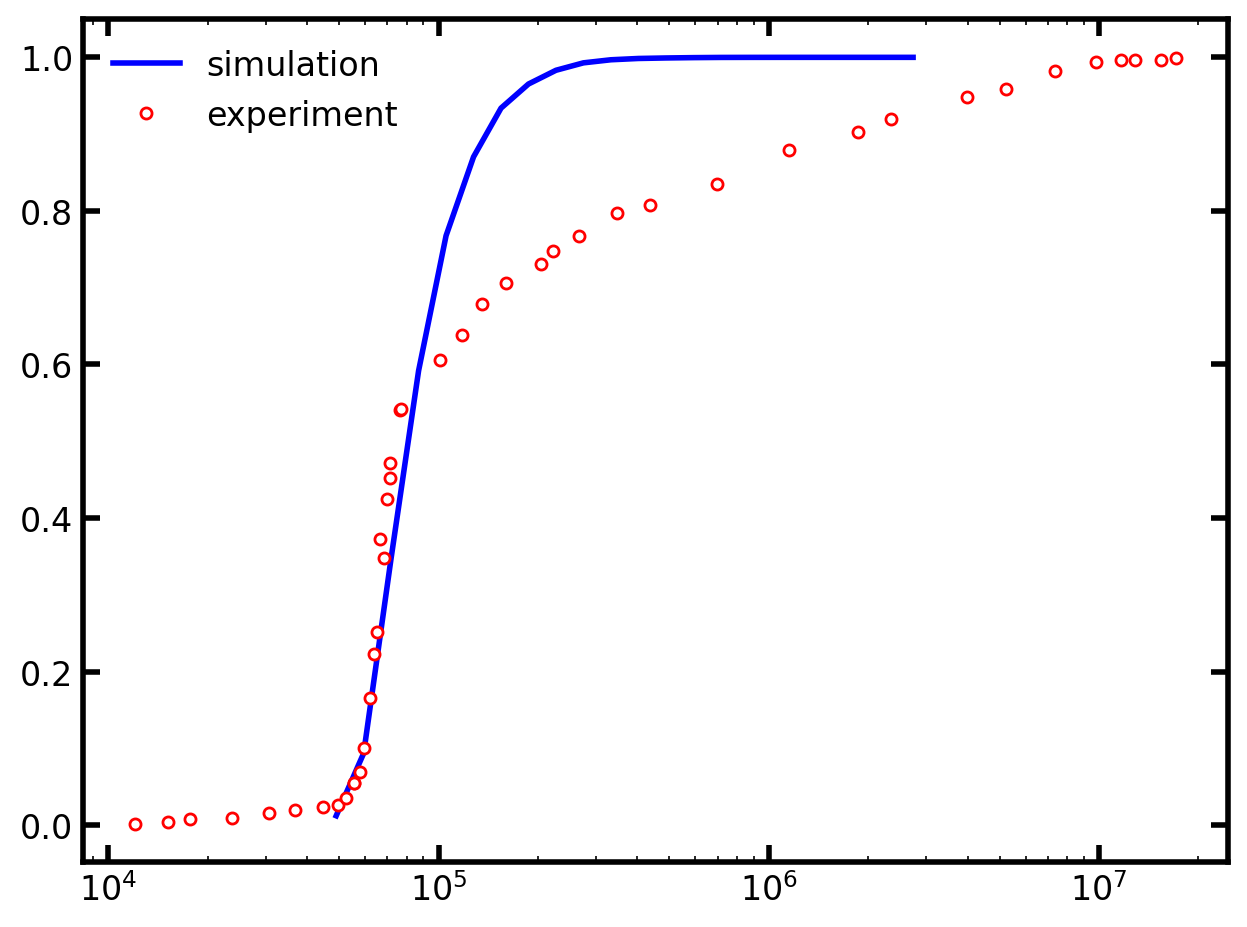

In [361]:
pn['pore.coords'] *= 50/30
pn.regenerate_models()
hg.regenerate_models()
mip = op.algorithms.Drainage(network=pn, phase=hg)
mip.set_inlet_BC(pores=pn.pores('surface'))
mip.run()
pc_sim = mip.pc_curve()
fig, ax = plt.subplots()
ax.semilogx(*pc_sim, 'b-', label='simulation')
ax.semilogx(df['Pc [Pa]'], df['S_Hg'], 'r.', label='experiment')
ax.legend();

The capillary pressure curve was not changed noticeably because the only thing that changed is the throat lengths (not sizes).  This adjustment has fixed the problem of negative throat lengths:

In [362]:
pn['throat.volume'].min()

9.000494059369823e-18

## Additional Calibration Steps

We could also check the permeability coefficient, formation factor (i.e. tortuosity), and porosity to ensure they also match, but this would require yet more iterating to find a suitable set of pore and throat sizes.

For instance, in the present case we can find the network porosity using:

In [364]:
(pn['pore.volume'].sum() + pn['throat.volume'].sum())/(15**3 * (50e-6)**3)

0.1687368766069287

This value is only slightly below the known value of 0.18.  This means the pores are spaced too far apart.  Instead of 50 um spacing, perhaps 48 um would have been better.